In [1]:
################################################################################
# MIT License
#
# Copyright (c) 2021 University of Amsterdam
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to conditions.
#
# Author: Deep Learning Course (UvA) | Fall 2022 & Oliver Gurney-Champion | Spring 2023
# Date modified: Jan 2023
################################################################################


# Import requiered packages
imports the packages and sets the random seed

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import random
import numpy as np
import helper_functions as hf
import torch
from matplotlib import pyplot as plt

# set random seed
seed =42

login to your free wandb account. Note you will need to set up your account on https://wandb.ai/authorize
wandb allows you to keep track of your neural network training.

In [6]:
import wandb
wandb.login()

wandb: Currently logged in as: sofia-garcia-nunes (sofia-garcia-nunes-vrije-universiteit-amsterdam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Simulate and view the IVIM data
Here, we split our data into a training set, validation set and test set. Note that the current implementation only uses the training set and it is up to you (in your exercises) to also implement the validation and test run. At this point, we already split the data for you.

In [7]:
# set b-values at which we "measure" (i.e. simulate signal)
bvalues=[0, 10, 20, 30, 50, 75, 100, 150, 300, 500, 700, 1000]

## Set the random seeds for reproducibility
np.random.seed(seed)
random.seed(seed)

#determine
batch_size = 128

with wandb.init(project="AI_for_medical_imaging", job_type="visualize data") as run:
    data_sim = hf.sim_signal(SNR=(10,40),bvalues=bvalues,sims=10000,seed=np.random.randint(1,10000))
    # Only for visualisation purposes: here we create our "Artifact" in wandb --> this allows viewing the data in your wandb account
    for i in range(4):
        #make b-value data pairs
        example_data=[[x,y] for (x,y) in zip(bvalues,data_sim[0][i])]
        # put it in a table
        table = wandb.Table(data=example_data, columns=["b-values", "signal"])
        #tell wandb to plot the table
        wandb.log({"data_plot " + str(i): wandb.plot.scatter(table, "b-values", "signal")})

    # here we split the data into train (70%), test (15%) and validation (15%) sets
    #split = int(np.floor(len(data_sim[0]) * 0.7))
    train_set, test_set, val_set = torch.utils.data.random_split([[data_sim[0][i,:],data_sim[1][i],data_sim[2][i],data_sim[3][i]] for i in range(len(data_sim[3]))],[0.7,0.15,0.15])
    #split = int(np.floor(len(rest) * 0.5))
    #test_set, val_set = torch.utils.data.random_split([[rest[0][i,:],rest[1][i],rest[2][i],rest[3][i]] for i in range(len(rest[3]))],[split, len(rest[0]) - split])

    # train loader loads the trianing data. We want to shuffle to make sure data order is modified each epoch and different data is selected each epoch.
    trainloader = torch.utils.data.DataLoader(train_set,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   drop_last=True)
    # validation data is loaded here. By not shuffling, we make sure the same data is loaded for validation every time. We can use substantially more data per batch as we are not training.
    inferloader = torch.utils.data.DataLoader(val_set,
                                   batch_size=batch_size,
                                   shuffle=False,
                                   drop_last=True)
        # validation data is loaded here. By not shuffling, we make sure the same data is loaded for validation every time. We can use substantially more data per batch as we are not training.
    testloader = torch.utils.data.DataLoader(test_set,
                                   batch_size=batch_size,
                                   shuffle=False,
                                   drop_last=True)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


3 A.	Program the different neural network modules (Lineairemodule, Relumodule, Tanhmodule, MSE) in “modules.py”. Use “do_unittest.py” to test whether the forward and backward passes are correct. Make only use of matrix multiplications, no for loops. Points will be deduced when for-loops are used where matrix multiplications were possible.
3 B.  Combine all modules into a multilayer perceptron (MLP) in “exercise_3.ipynb”. Use ReLU activation functions after each fully connected linear module, except for the last module, after which a Tanh module should be used (constraining parameters between [-1, 1]). The number of layers and number of nodes per layer should be adjustable


In [17]:
"""
This module implements a multi-layer perceptron (MLP) in NumPy.
You should fill in code into indicated sections.
"""
from modules import MLP, MSE, LinearModule #you need to adapt these



# Exercise 3C-D
C.	Train the neural network using just python and numpy code. You can find modules in "modules.py" which you will first have to fill in and train. You can then use these modules here!

You can use "do_unittest.py" to test whether the modules from "modules.py" have been implemented correctly.

You will need to add the updating of the gradients. As a sanity check, a network with 2 layers (64, 32), combined with a lr of 0.001, 30 epochs, and a batch size of 128 should work reasonably well and result in a systematic error of around 0.2% and a random error of around 20%.

D.	It now uses the mini-batch stochastic gradient descent algorithm. Add momentum to the training update of the weights.


In [41]:
# define parameters
hidden_layers=(64,32)
model=MLP(len(bvalues), hidden_layers, 1)
epochs = 30
learning_rate = 0.001

# initialize wandb
wandb.init(
        project="AI_for_medical_imaging", job_type="training")

loss_module1 = MSE()

# set random seed for reproducibility
torch.manual_seed(seed)

# probe available devices
if torch.cuda.is_available():  # GPU operation have separate seed
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.determinstic = True
    torch.backends.cudnn.benchmark = False

sys_val_list_b = []
SD_val_list_b = []

# loop over epochs
for epoch in range(epochs):
    # initiate losses to 0
    train_loss_f = 0
    val_loss_f = 0
    sys_train, SD_train, sys_val, SD_val = 0,0,0,0
    #loop over all training data
    for x in trainloader:
        # get data (x[0]) and put the data on the GPU if available
        batch=x[0].numpy()
        # get the reference f (x[2]) --> note x[1] and x[3] are D and Dp respectively
        f_ref = np.expand_dims(x[2].numpy(),axis=1)
        # put the data through the neural network
        f_pred = model.forward(batch)
        # calculate loss (compare predicted f to the ground trueth)
        train_loss_f += np.mean(loss_module1.forward(f_pred, f_ref))
        # propogate the loss through the network (calculate d_wights/d_loss)
        model.backward(loss_module1.backward())

        # sys and SD error
        sys_train += np.mean(f_pred - f_ref)
        SD_train += np.std(f_pred - f_ref)

        #######################
        # PUT YOUR CODE HERE  #
        #######################
        # updating the gradients
        for layer in model.LM:
            layer.weights -= learning_rate * layer.grads['weight']
            layer.bias -= learning_rate * layer.grads['bias']


    for x in inferloader:
        batch=x[0].numpy()
        f_ref = np.expand_dims(x[2].numpy(),axis=1)
        f_pred = model.forward(batch)
        val_loss_f += np.mean(loss_module1.forward(f_pred, f_ref))

        sys_val += np.mean(f_pred - f_ref)
        SD_val += np.std(f_pred - f_ref)

        #######################
        # END OF YOUR CODE    #
        #######################
        model.clear_cache()
    
    sys_val_list_b.append(np.mean(f_pred - f_ref))
    SD_val_list_b.append(np.std(f_pred - f_ref))
    
    # get final sys and SD
    sys_val_batch = sys_val/inferloader.__len__()
    SD_val_batch = SD_val/inferloader.__len__()

    wandb.log({"loss/train": train_loss_f/trainloader.__len__(),"loss/val": val_loss_f/inferloader.__len__(),"error/random error":SD_val_batch,"error/systematic error":sys_val_batch})
    print('epoch = ' + str(epoch) + ' train loss =' + str(train_loss_f/trainloader.__len__()) +' val loss =' + str(val_loss_f/inferloader.__len__()) + 'the systematic error is ' + str(sys_val_batch) + ' and the random error is ' + str(SD_val_batch))

epoch = 0 train loss =0.15261217051811407 val loss =0.13512346445660436the systematic error is -0.30610085536216336 and the random error is 0.20286557827008228
epoch = 1 train loss =0.1307794753863435 val loss =0.11635281562747496the systematic error is -0.2737213200013047 and the random error is 0.202874694921404
epoch = 2 train loss =0.1136301475840403 val loss =0.10137868506827961the systematic error is -0.24484099367658663 and the random error is 0.2028798753313106
epoch = 3 train loss =0.0994616151557375 val loss =0.08948973279507903the systematic error is -0.2192195404576495 and the random error is 0.20288221032005135
epoch = 4 train loss =0.08835951233227568 val loss =0.08000985901466154the systematic error is -0.19641007091796958 and the random error is 0.2028832303792334
epoch = 5 train loss =0.07952941947826923 val loss =0.07244900722964663the systematic error is -0.17611339524996047 and the random error is 0.2028835615792478
epoch = 6 train loss =0.07235501073707015 val loss

In [48]:
# Define momentum parameter
momentum = 0.9

# Initialize velocity terms for weights and biases
velocity_w = {layer: np.zeros_like(layer.weights) for layer in model.LM}
velocity_b = {layer: np.zeros_like(layer.bias) for layer in model.LM}

sys_val_list_m = []
SD_val_list_m = []
# loop over epochs
for epoch in range(epochs):
    train_loss_f = 0
    val_loss_f = 0
    sys_train, SD_train, sys_val_momentum, SD_val_momentum = 0, 0, 0, 0

    # Loop over all training data
    for x in trainloader:
        batch = x[0].numpy()
        f_ref = np.expand_dims(x[2].numpy(), axis=1)

        # Forward pass
        f_pred = model.forward(batch)

        # Compute loss
        train_loss_f += np.mean(loss_module1.forward(f_pred, f_ref))

        # Backpropagation
        grads = loss_module1.backward()
        model.backward(grads)

        # Update weights with momentum
        for layer in model.LM:
            velocity_w[layer] = momentum * velocity_w[layer] - learning_rate * layer.grads['weight']
            velocity_b[layer] = momentum * velocity_b[layer] - learning_rate * layer.grads['bias']

            layer.weights += velocity_w[layer]
            layer.bias += velocity_b[layer]

        # Compute systematic and standard deviation errors
        sys_train += np.mean(f_pred - f_ref)
        SD_train += np.std(f_pred - f_ref)

    
    # Validation phase
    for x in inferloader:
        batch = x[0].numpy()
        f_ref = np.expand_dims(x[2].numpy(), axis=1)
        f_pred = model.forward(batch)
        val_loss_f += np.mean(loss_module1.forward(f_pred, f_ref))

        sys_val_momentum += np.mean(f_pred - f_ref)
        SD_val_momentum += np.std(f_pred - f_ref)

        model.clear_cache()

    sys_val_list_m.append(np.mean(f_pred - f_ref))
    SD_val_list_m.append(np.std(f_pred - f_ref))

    # Compute final systematic and random errors
    sys_val_momentum /= len(inferloader)
    SD_val_momentum /= len(inferloader)

    # Log results to WandB
    wandb.log({
        "loss/train": train_loss_f / len(trainloader),
        "loss/val": val_loss_f / len(inferloader),
        "error/random error": SD_val_momentum,
        "error/systematic error": sys_val_momentum
    })

    print(f'epoch = {epoch} train loss = {train_loss_f / len(trainloader)} val loss = {val_loss_f / len(inferloader)} systematic error = {sys_val_momentum} random error = {SD_val_momentum}')

epoch = 0 train loss = 0.04048197309922699 val loss = 0.04119039106386901 systematic error = 0.00957655722056441 random error = 0.20206324938037154
epoch = 1 train loss = 0.0405086000329033 val loss = 0.041192851620519666 systematic error = 0.010237417070602418 random error = 0.20203710759763957
epoch = 2 train loss = 0.0404638712273782 val loss = 0.04117472343745501 systematic error = 0.009915084915070605 random error = 0.20200850677154467
epoch = 3 train loss = 0.04041492830872967 val loss = 0.04116525940665963 systematic error = 0.01003114504340822 random error = 0.20197954123023518
epoch = 4 train loss = 0.040505962212106436 val loss = 0.04113071074982482 systematic error = 0.008896347994128704 random error = 0.20194739652800087
epoch = 5 train loss = 0.04053868866131984 val loss = 0.041132499899891796 systematic error = 0.009665990392882965 random error = 0.20191665514141774
epoch = 6 train loss = 0.04039783123636937 val loss = 0.041109702585507654 systematic error = 0.00918981626

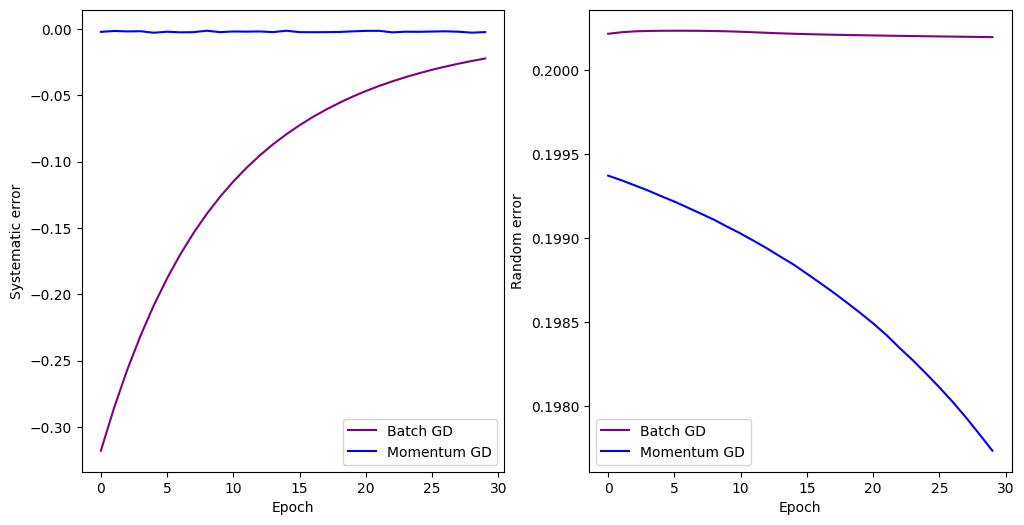

In [49]:
# Plot the sys and SD errors for the batch and momentum GD in two side by side plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(sys_val_list_b, label='Batch GD', color = 'purple')
plt.plot(sys_val_list_m, label='Momentum GD', color = 'blue')
plt.xlabel('Epoch')
plt.ylabel('Systematic error')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(SD_val_list_b, label='Batch GD', color = 'purple')
plt.plot(SD_val_list_m, label='Momentum GD', color = 'blue')
plt.xlabel('Epoch')
plt.ylabel('Random error')
plt.legend()

plt.show()